# Analysis I: The problem of variability across analysis teams
Here we will describe the problem of analytical variability, how analyses impact results. To this end, we will highlight the differences in pipeline choices and visualize the range in results to get an idea of how much variation is present in the methods and results from different analysis teams. Further, in order to explore which methodological choices introduce the most variance across teams, we will use partial least squares (PLS; \citealp{mcintosh2013multivariate, mcintosh2004partial}) to associate methodological choices with the group-level maps from each analysis team. 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import functions as fun # functions mostly written by Alexendre Perez (and some by me)
from nistats import thresholding
import numpy as np
import nibabel as nib
import nilearn
from nilearn import masking, plotting, image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import shutil
import os
import scipy.stats as st
import pickle

template = nilearn.datasets.load_mni152_template()
affine = template.affine

level = .05

save_figs = True
save_results = False
run_long_analyses = False

hypothesis = 1

%matplotlib inline

200204-18:11:36,152 nipype.utils INFO:
	 Running nipype version 1.3.1 (latest: 1.4.1)


INFO:nipype.utils:Running nipype version 1.3.1 (latest: 1.4.1)


## Pipelines
### Load spreadsheet with pipelines from each analysis team
This is a selection of columns that look quantifiable (i.e., I excluded descriptive columns, etc)

In [2]:
import csv
pipelines_file = '../data-narps/narps_pipelines.csv'
pipel_str = pd.read_csv(pipelines_file)
pd.set_option('display.max_rows', pipel_str.shape[0]+1)

# remove spaces
pipel_str = fun.df_strip(pipel_str)

# select rows for files that we have
teams_in_spreadsheet = pipel_str['NV_collection_string']
team_list = fun.get_list_of_teams_we_have(teams_in_spreadsheet)
pipel_str.set_index("NV_collection_string", inplace=True)
pipel_str = pipel_str.loc[team_list]
pipel_str.insert(0, "NV_collection_string", team_list, True)
pipel_str.insert(0, "Index", np.arange(len(pipel_str)), True)
pipel_str.set_index("Index", inplace=True)
pipel_str

,NV_collection_string,Unnamed: 0,TSc_SW,used_fmriprep_data,TSc_smoothing,TSc_testing
Index,,,,,,
0,ADFZYYLQ,C88N,SPM,Yes,8,GRTFWE
1,BEWWYWBV,5G9K,SPM,Yes,4,GRTFWE
2,CGGOUIDK,X1Y5,randomise,Yes,4,Randomise
3,CLTGPQPO,43FJ,FSL,No,5,GRTFWE
4,CMGDLXNE,C22U,FSL,No,5,GRTFWE
5,COXUJKNY,R9K3,SPM12,Yes,6,None
6,CQCJIRXE,O03M,AFNI,Yes,0,ClustSim
7,DLIKXMQO,3TR7,SPM12,Yes,8,FDR
8,EDFRMJVJ,9Q6R,FSL,No,5,GRTFWE


### Turn columns with multiple values into booleans

In [3]:
columns_to_be_booleaned = ['used_fmriprep_data','TSc_SW','TSc_testing']
numerical_columns = ['TSc_smoothing']
for column in columns_to_be_booleaned:
    unique_strs = pipel_str[column].unique()
    for unique_str in unique_strs:
        if unique_str != 'No':
            str_in_col = pipel_str[column].str.find(unique_str)
            new_col_name = column + '_' + unique_str
            pipel_str[new_col_name] = str_in_col + 1  
            numerical_columns.append(new_col_name)
            
pipel_num = pipel_str[numerical_columns]

SPM = pipel_num['TSc_SW_SPM'] - pipel_num['TSc_SW_SPM12']
pipel_num['TSc_SW_SPM'] = SPM
pipel_str.reset_index()

pipel_num

,TSc_smoothing,used_fmriprep_data_Yes,TSc_SW_SPM,TSc_SW_randomise,TSc_SW_FSL,TSc_SW_SPM12,TSc_SW_AFNI,TSc_SW_nistats,TSc_SW_Other,TSc_testing_GRTFWE,TSc_testing_Randomise,TSc_testing_None,TSc_testing_ClustSim,TSc_testing_FDR,TSc_testing_TFCE,TSc_testing_SnPM,TSc_testing_ETAC,TSc_testing_BSR
Index,,,,,,,,,,,,,,,,,,
0,8,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
5,6,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
7,8,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


## Visualize

fmriprep Y,N:  [31, 23]
software [1, 3, 4, 4, 8, 16, 18]
testing  [1, 1, 1, 2, 4, 5, 6, 11, 23]


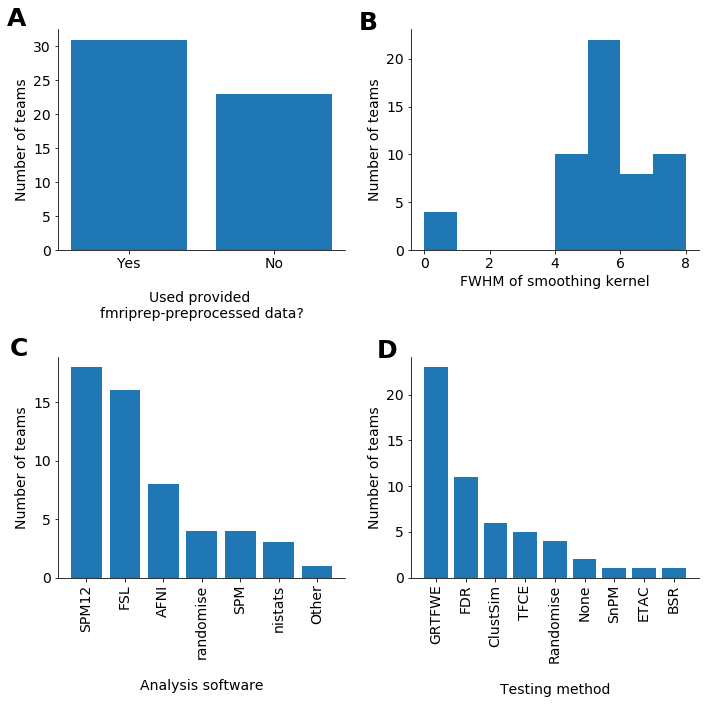

In [4]:
from matplotlib.gridspec import GridSpec

letter_font_size = 25
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,2, figure=fig)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])

# Used provided fmriprep data?
col = pipel_num['used_fmriprep_data_Yes']
labels = ['Yes', 'No']
x_pos = np.arange(len(labels))
counts = [np.sum(col), len(col) - np.sum(col)]
print('fmriprep Y,N: ', counts)
order = np.argsort(counts)
counts.sort()
labels = np.array(labels)
labels = labels[order]
ax1.bar(x_pos, counts[::-1], align='center')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels[::-1])
ax1.set_xlabel('Used provided \nfmriprep-preprocessed data?', labelpad=20)
#ax1.set_yticks(range(0,36, 5))
ax1.set_ylabel('Number of teams')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
height = int(round(ax1.get_ylim()[1]))
ax1.text(-.84, height, s='A', fontsize=letter_font_size, weight='bold')
plt.tight_layout()

# FWHM of smoothing kernel
ax2.hist(pipel_str['TSc_smoothing'], bins=np.max(pipel_str['TSc_smoothing']))
ax2.set_xlabel('FWHM of smoothing kernel')
ax2.set_ylabel('Number of teams')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
height = int(round(ax2.get_ylim()[1]))
ax2.text(-2, height, s='B', fontsize=letter_font_size, weight='bold')
plt.tight_layout()

# Software used to get results maps
labels = np.unique(pipel_str['TSc_SW'])
cols = ['TSc_SW_' + label for label in labels]
x_pos = np.arange(len(labels))
counts = [np.sum(pipel_num[col]) for col in cols]
order = np.argsort(counts)
counts.sort()
print('software', counts)
labels = np.array(labels)
labels = labels[order]
ax3.bar(x_pos, counts[::-1], align='center')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels[::-1], rotation='vertical')
ax3.set_xlabel('Analysis software', labelpad=20)
#ax3.set_yticks(range(0,36, 5))
ax3.set_ylabel('Number of teams')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
height = int(round(ax3.get_ylim()[1]))
ax3.text(-2, height, s='C', fontsize=letter_font_size, weight='bold')
plt.tight_layout()

# Software used to test SPMs
labels = np.unique(pipel_str['TSc_testing'])
cols = ['TSc_testing_' + label for label in labels]
x_pos = np.arange(len(labels))
counts = [np.sum(pipel_num[col]) for col in cols]
order = np.argsort(counts)
counts.sort()
print('testing ', counts)
labels = np.array(labels)
labels = labels[order]
ax4.bar(x_pos, counts[::-1], align='center')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(labels[::-1], rotation='vertical')
ax4.set_xlabel('Testing method', labelpad=20)
ax4.set_ylabel('Number of teams')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
height = int(round(ax4.get_ylim()[1]))
ax4.text(-2, height, s='D', fontsize=letter_font_size, weight='bold')
plt.tight_layout()

plt.savefig('../figures/final_figures_paper/result1A_methods_histograms.png')


## Compare study results across pipelines

### Get lists of studies based on analysis software

In [5]:
files = pipel_str['NV_collection_string']
SPM12 = files[pipel_num['TSc_SW_SPM12']>0]
FSL = files[pipel_num['TSc_SW_FSL']>0]
fmriprepY = files[pipel_num['used_fmriprep_data_Yes']>0]
fmriprepN = files[pipel_num['used_fmriprep_data_Yes']<1]

### Load neuroimaging data

In [6]:
# Image paths
img_paths = fun.get_data_paths_from_orig('hypo%d_unthresh.nii.gz' %hypothesis)
img_paths.sort()
img_paths_SPM12 = fun.get_path_list_from_team_list(SPM12, img_paths)
img_paths_FSL = fun.get_path_list_from_team_list(FSL, img_paths)
img_paths_fmriprepY = fun.get_path_list_from_team_list(fmriprepY, img_paths)
img_paths_fmriprepN = fun.get_path_list_from_team_list(fmriprepN, img_paths)

# Matrices of the images
imgs_all = fun.img_paths_to_matrix_of_imgs(img_paths)
imgs_SPM12 = fun.img_paths_to_matrix_of_imgs(img_paths_SPM12)
imgs_FSL = fun.img_paths_to_matrix_of_imgs(img_paths_FSL)
imgs_fpY = fun.img_paths_to_matrix_of_imgs(img_paths_fmriprepY)
imgs_fpN = fun.img_paths_to_matrix_of_imgs(img_paths_fmriprepN)

### Mean activation

In [7]:
team_axis = 0
mean_all = np.mean(imgs_all, axis=team_axis)
mean_SPM12 = np.mean(imgs_SPM12, axis=team_axis)
mean_FSL = np.mean(imgs_FSL, axis=team_axis)
mean_fpY = np.mean(imgs_fpY, axis=team_axis)
mean_fpN = np.mean(imgs_fpN, axis=team_axis)

### Analytic range

In [8]:
range_all = np.abs(np.max(imgs_all, axis=team_axis) - np.min(imgs_all, axis=team_axis))
range_SPM12 = np.abs(np.max(imgs_SPM12, axis=team_axis) - np.min(imgs_SPM12, axis=team_axis))
range_FSL = np.abs(np.max(imgs_FSL, axis=team_axis) - np.min(imgs_FSL, axis=team_axis))
range_fpY = np.abs(np.max(imgs_fpY, axis=team_axis) - np.min(imgs_FSL, axis=team_axis))
range_fpN = np.abs(np.max(imgs_fpN, axis=team_axis) - np.min(imgs_FSL, axis=team_axis))

### Visualize

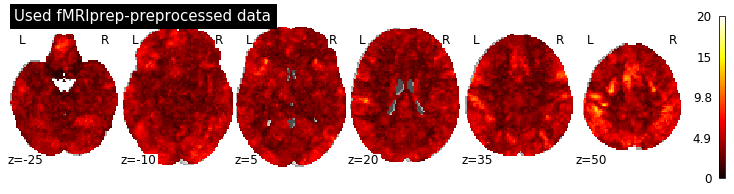

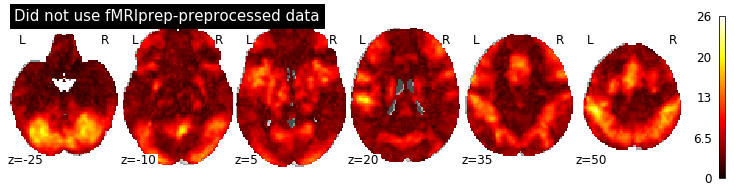

In [9]:
%matplotlib inline
order = 'C'
z_cut_coords = np.arange(-25, 65, 15)
brain_fig_size = (10,2.5)
font = {'size'   : 12}
matplotlib.rc('font', **font)

maps = { 
    #'Mean activation of all images': mean_all,
    #'Mean activation of images using SPM12 for getting test stats': mean_SPM12,
    #'Mean activation of images using FSL for getting test stats': mean_FSL,
    #'Mean activation of images using fmriprep-preprocessed data': mean_fpY,
    #'Mean activation of images not using fmriprep-preprocessed data': mean_fpN,
    #'Analytic range of all images': range_all,
    #'Analytic range of images using SPM12 for getting test stats': range_SPM12,
    #'Analytic range of images using FSL for getting test stats': range_FSL,
    'Used fMRIprep-preprocessed data': range_fpY,
    'Did not use fMRIprep-preprocessed data': range_fpN,
    #
}

for name, img in maps.items():
    nii = fun.flat_mat_to_nii(flat_mat=img, ref_niimg=template, order=order)
    plotting.plot_stat_map(nii, 
                           title=name, 
                           display_mode='z',
                           cut_coords=z_cut_coords,
                           figure=plt.figure(figsize=brain_fig_size))
    
    if save_figs: plt.savefig('../figures/final_figures_paper/results1B_hypo%d_%s.png'\
                                  %(hypothesis, name.replace(' ', '-')))
    #if save_results: nii.to_filename('../data-narps/results1B_hypo%d_%s.nii.gz' \
    #                              %(hypothesis, name.replace(' ', '-')))

## PLS

### Get pipeline data into a matrix
We can't take the z-score because it's boolean data, but I scaled the first column (smoothing kernel) between 0 and 1, since that's the closest I can think of to a boolean. 

In [10]:
YY = pipel_num.as_matrix()
Y = np.copy(YY)
smoothing = Y[:,0]
rng = np.max(Y[:,0]) - np.min(Y[:,0])
smoothing_normalized = smoothing/rng
a = np.expand_dims(smoothing_normalized, axis=0)
Y = np.delete(Y, 0, axis=1)
Y = np.concatenate((a, Y.T), axis=0).T

### Get image data into a matrix
and take the z-score within each image

In [11]:
X = imgs_all
team_axis = 1
Xz = st.zscore(X, ddof=1, axis=team_axis)
print(Xz.shape)

(54, 902629)


### Singular value decomposition
First, we'll construct a cross-correlation matrix from ``X`` and ``Y``. This
matrix will represent the correlation between every voxel's activation and
the pipeline choices across all analysis teams.

We can decompose that matrix using an SVD to generate left and right singular
vectors (``U`` and ``V``) and a diagonal array o}f singular values (``sval``).


In [12]:
from scipy.linalg import svd

cross_corr = (Y.T @ Xz) / (len(Xz) - 1)
U, sval, V = svd(cross_corr.T, full_matrices=False)
V = V.T  # Transpose this so we have a feature x component array
print('U shape: {}'.format(U.shape),
      'V shape: {}'.format(V.shape), sep='\n')

U shape: (902629, 18)
V shape: (18, 18)


The rows of U correspond to the voxels in our X matrix.\
The rows of V correspond to the pipeline choices. \
The columns of U and V represent new "dimensions" that have been found in the data.

The "dimensions" obtained with PLS are estimated such that they maximize the correlation between the values of our X and Y matrices projected onto these new dimensions. As such, a good sanity check is to examine the correlation between these projected scores for all the components; if the correlations are low then we should interpret the results of the PLS with caution.

Here we will use Spearman's correlation because the data is categorical. 

In [13]:
# Project samples to the derived space
x_scores, y_scores = Xz @ U, Y @ V
corrs = []
for comp in range(x_scores.shape[-1]):
    
    # Correlate the sample scores for each component
    corr = st.spearmanr(x_scores[:, comp], y_scores[:, comp])
    print('Component {:>2}: r = {:.2f}, p = {:.3f}'.format(comp, *corr))
    corrs.append(corr[0])

Component  0: r = 0.52, p = 0.000
Component  1: r = 0.76, p = 0.000
Component  2: r = 0.59, p = 0.000
Component  3: r = 0.85, p = 0.000
Component  4: r = 0.81, p = 0.000
Component  5: r = 0.47, p = 0.000
Component  6: r = 0.66, p = 0.000
Component  7: r = 0.49, p = 0.000
Component  8: r = 0.65, p = 0.000
Component  9: r = 0.63, p = 0.000
Component 10: r = 0.53, p = 0.000
Component 11: r = 0.46, p = 0.001
Component 12: r = 0.68, p = 0.000
Component 13: r = 0.66, p = 0.000
Component 14: r = 0.49, p = 0.000
Component 15: r = 0.51, p = 0.000
Component 16: r = -0.01, p = 0.929
Component 17: r = -0.07, p = 0.605


To dig into things a bit more we can also calculate the correlation of the
original pipeline choices (from the ``Y`` matrix) with the values of our ``X``
matrix projected to the PLS space (i.e., ``x_scores``, from above). This will
give us an idea of which pipelines choices are most (or least) correlated with
the *overall* activation maps.

We can look at these correlations for the first component to get an idea of
things.

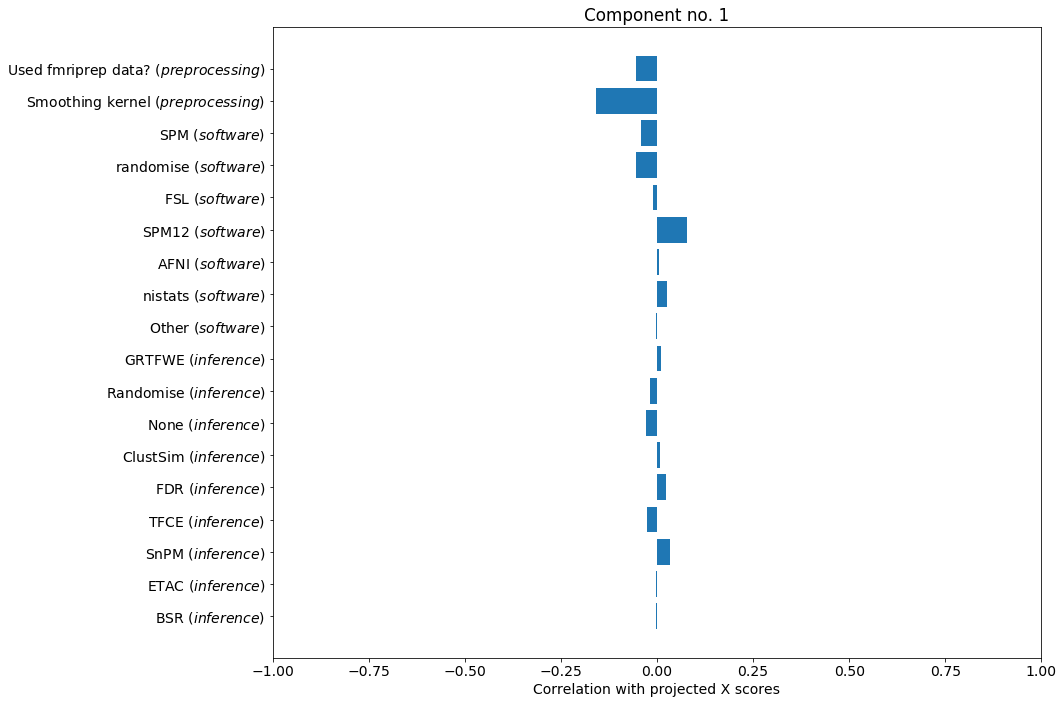

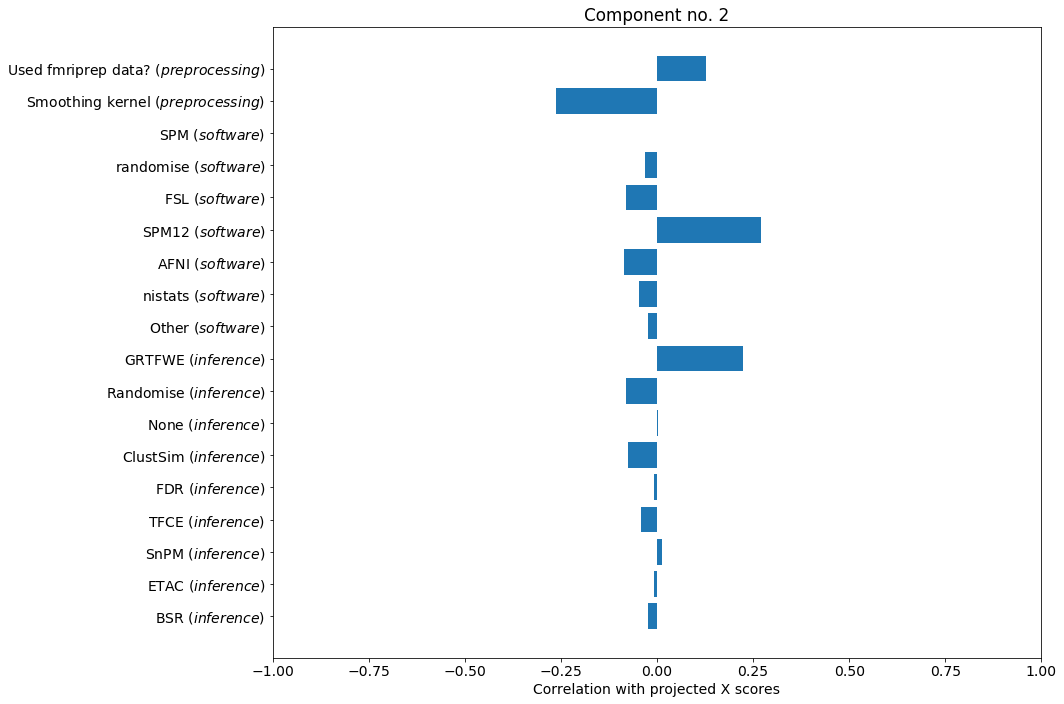

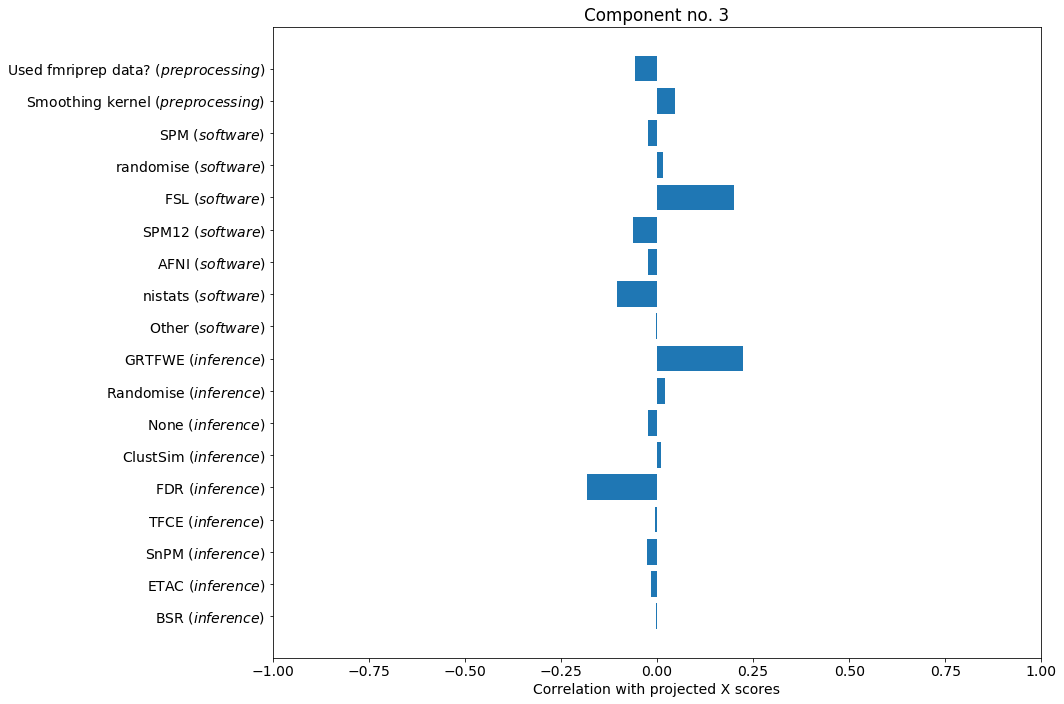

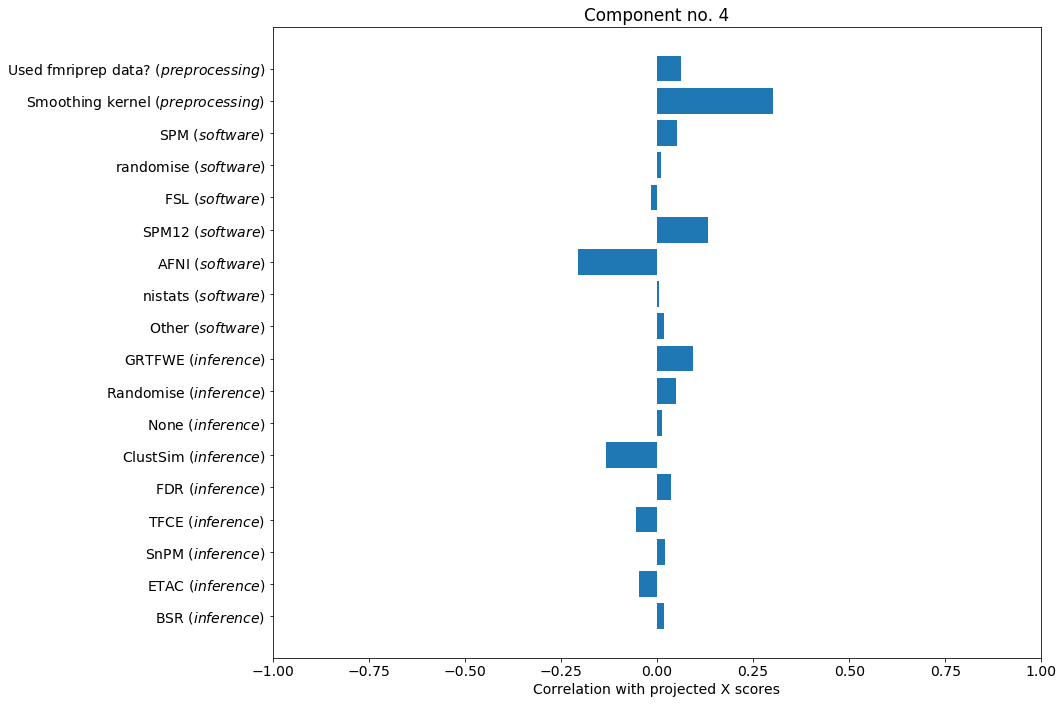

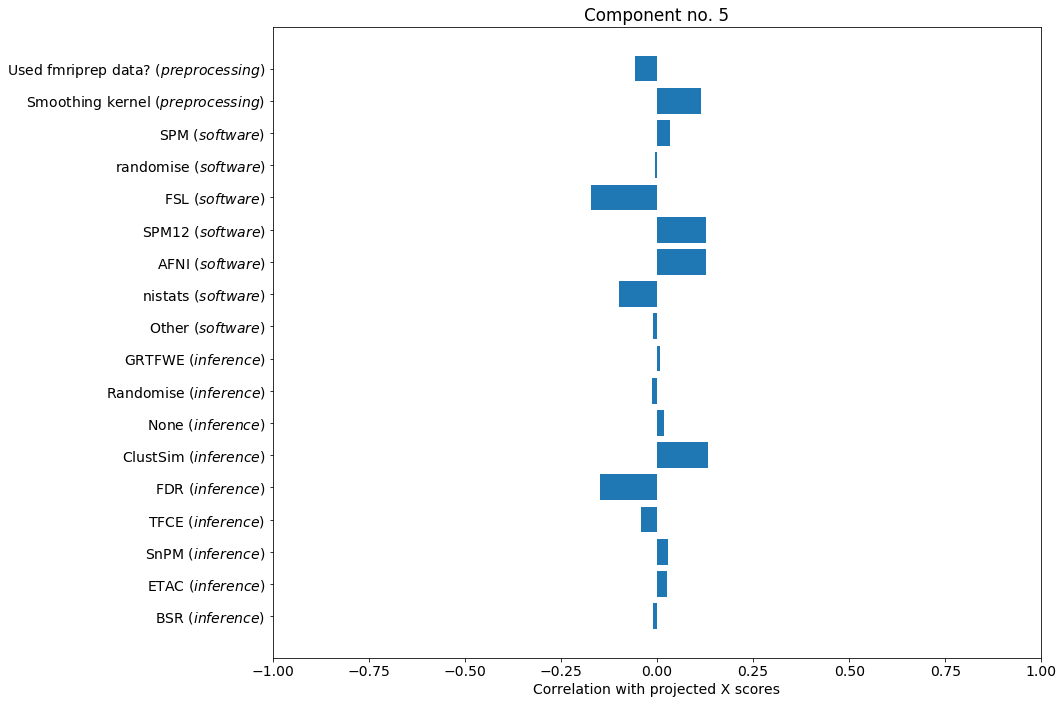

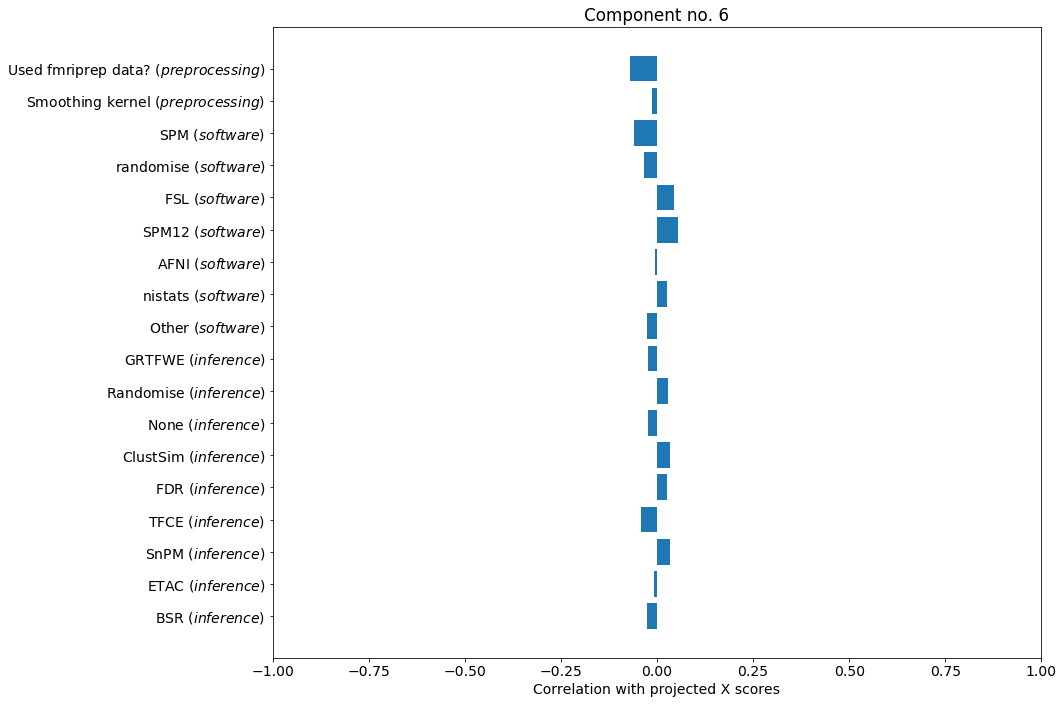

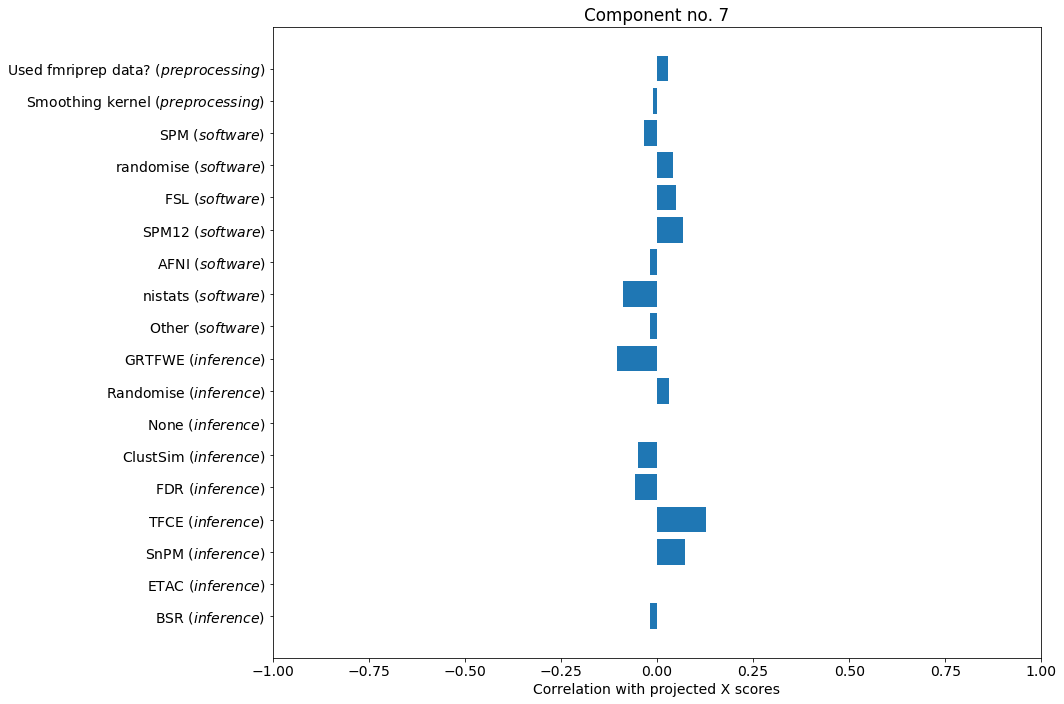

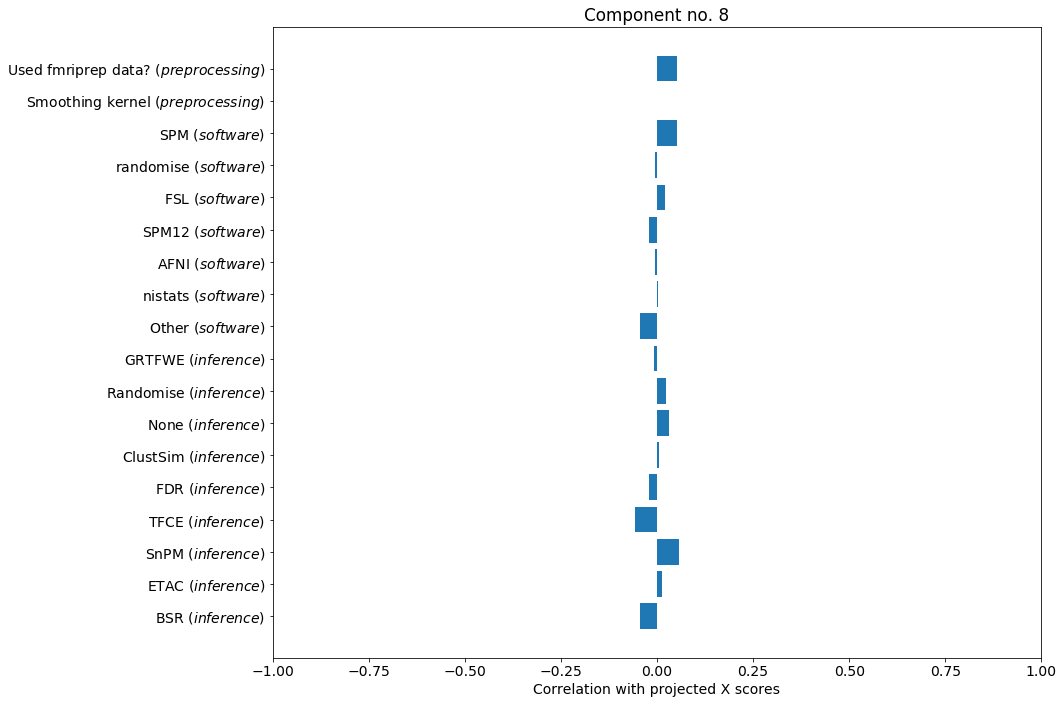

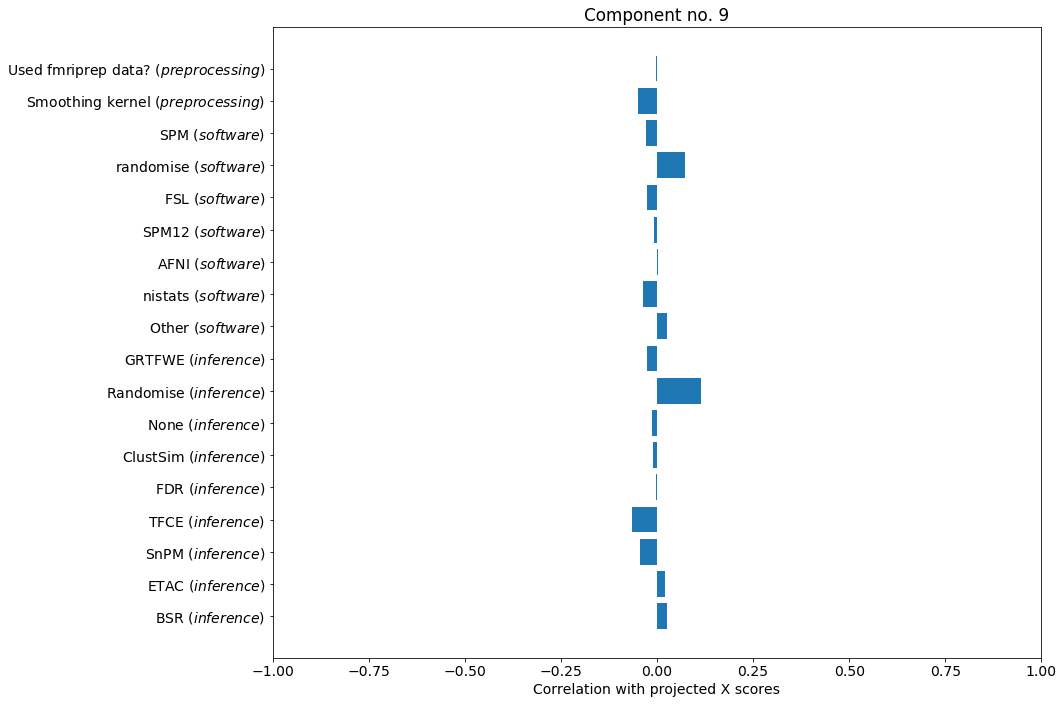

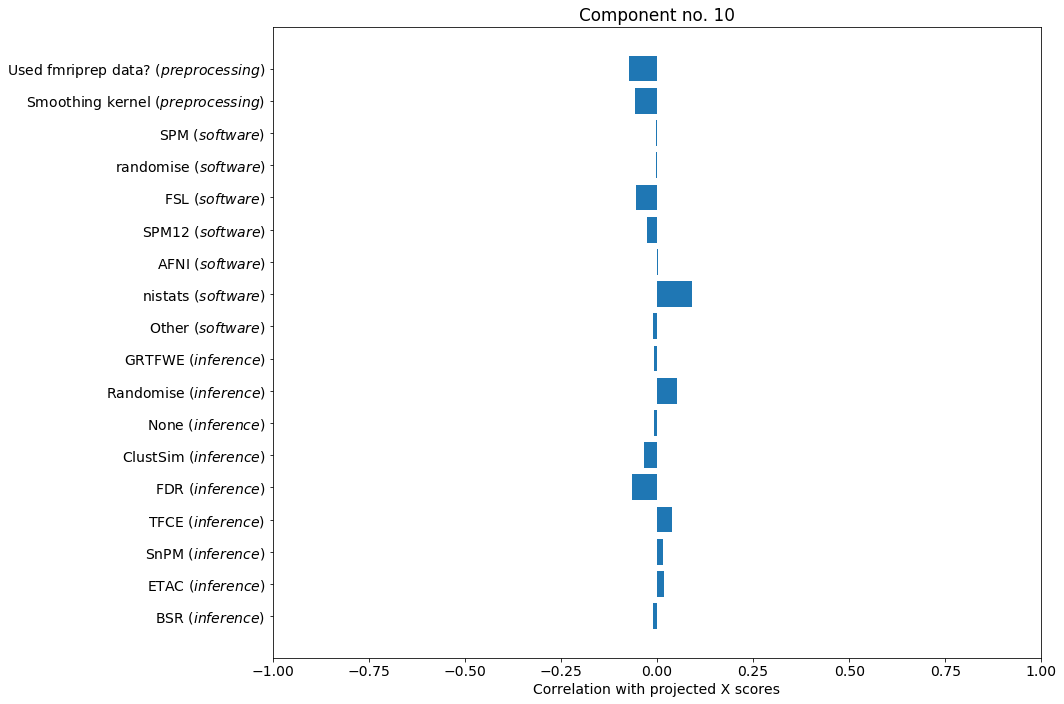

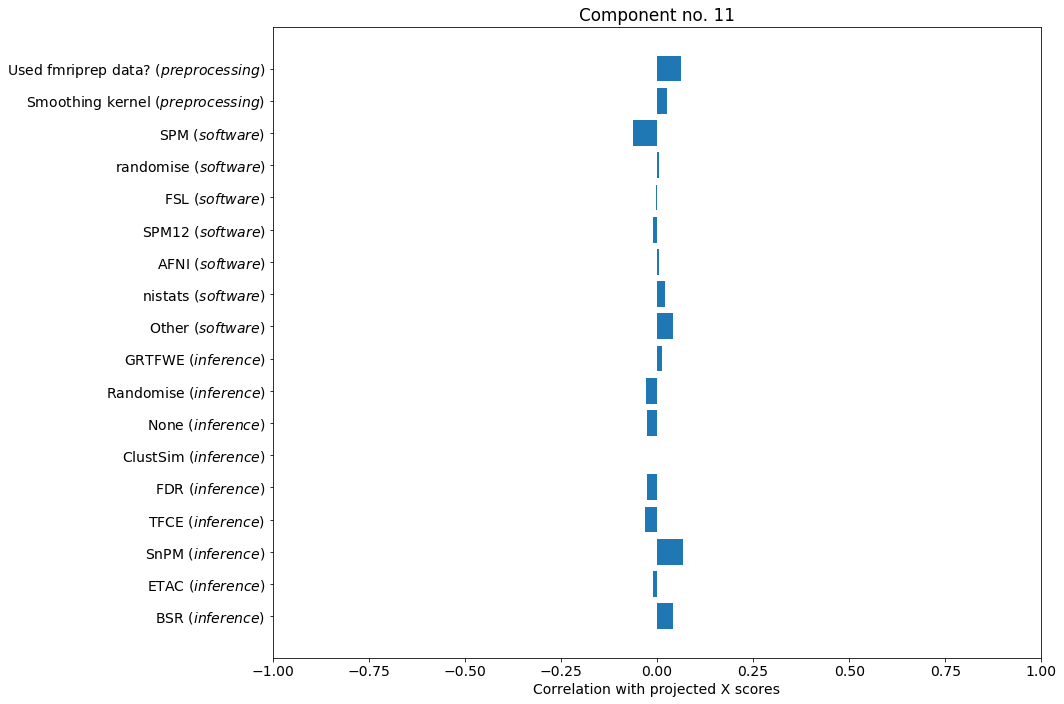

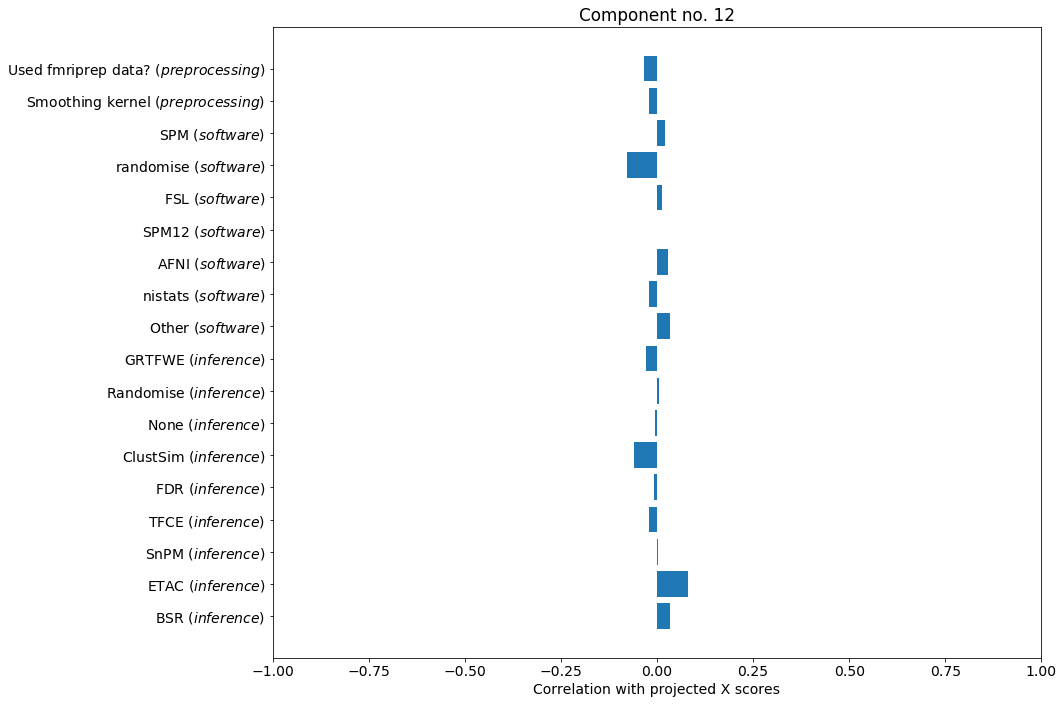

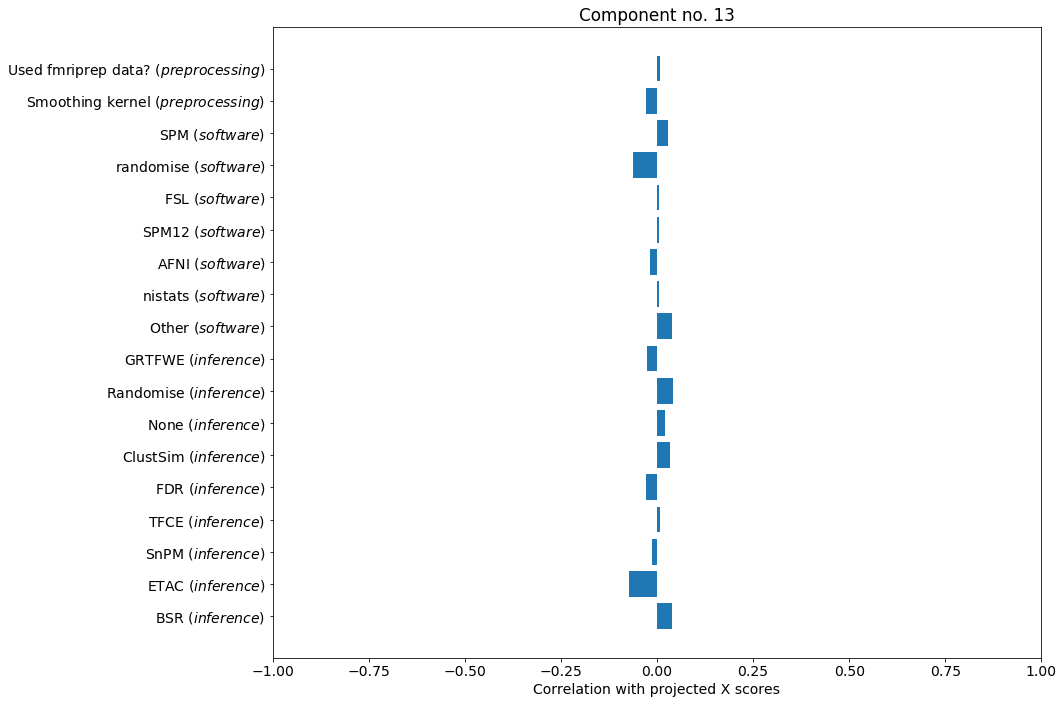

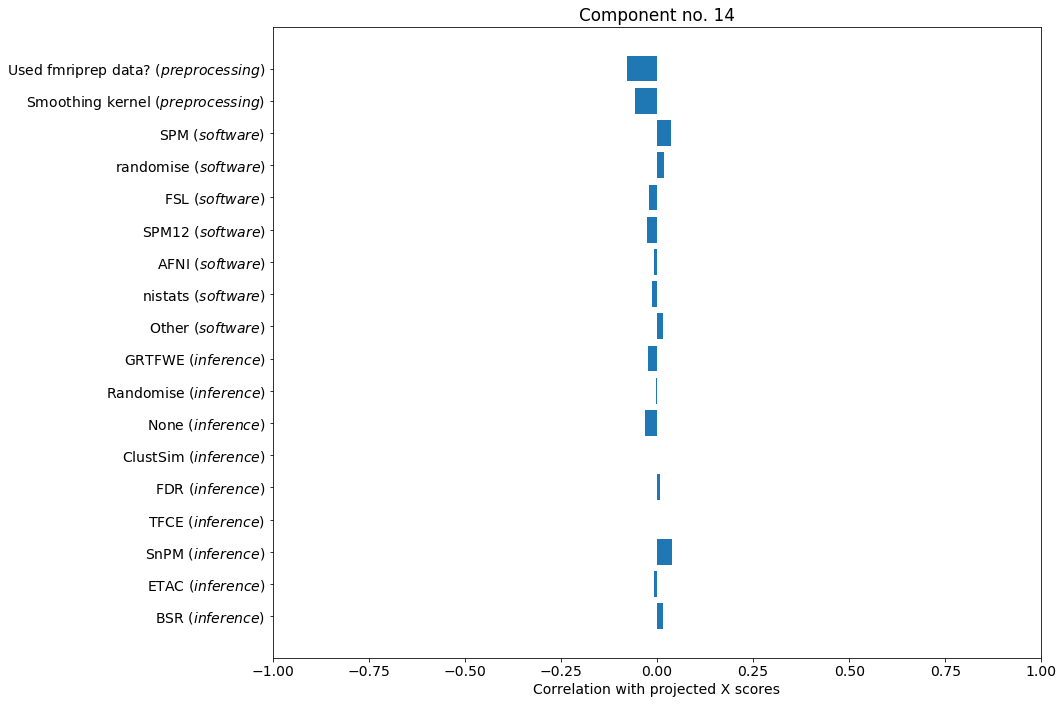

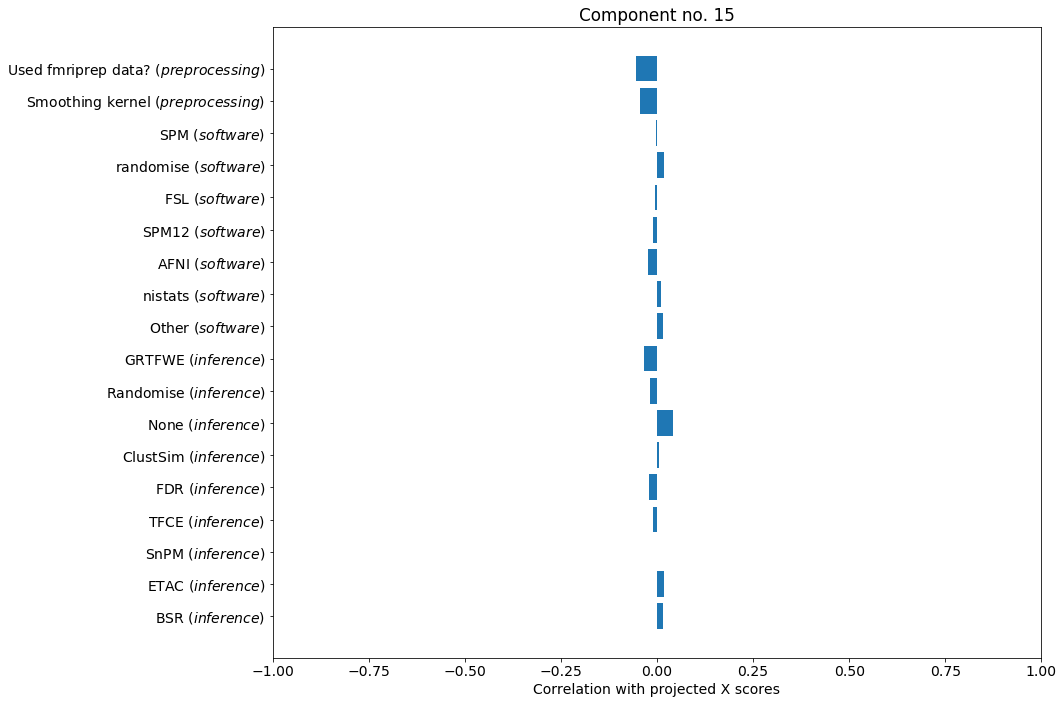

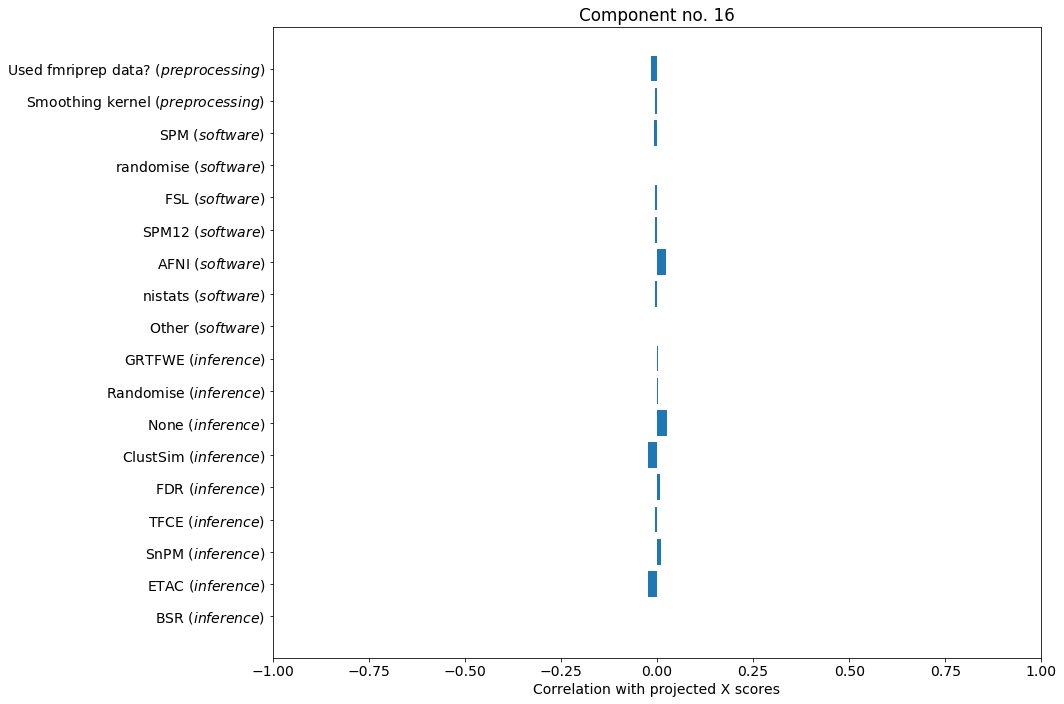

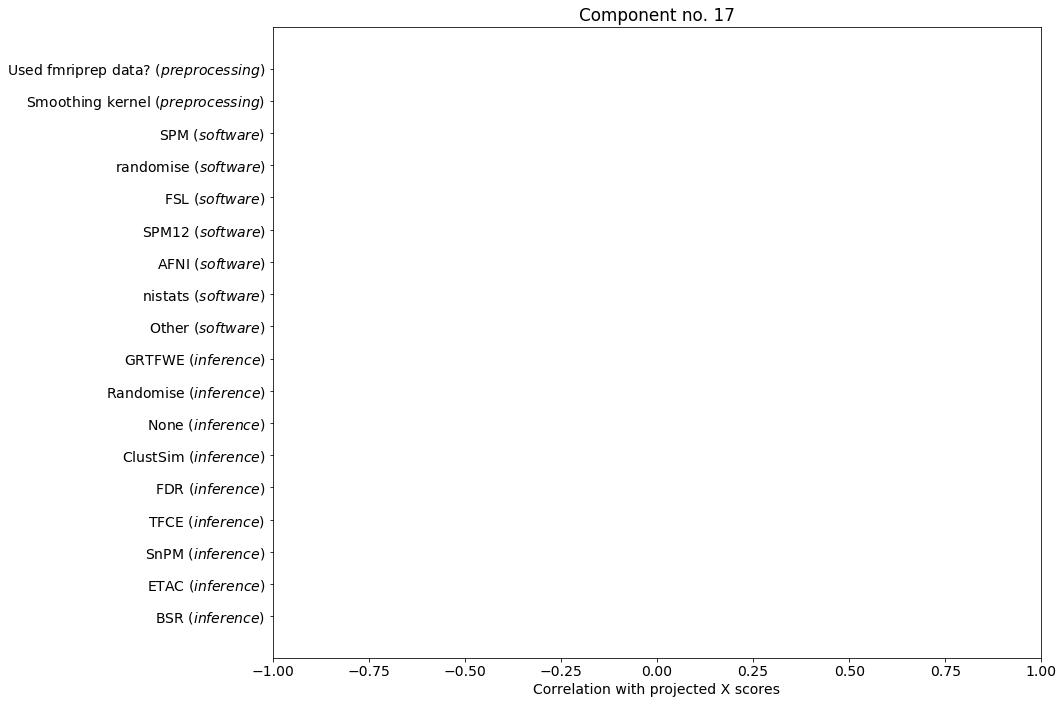

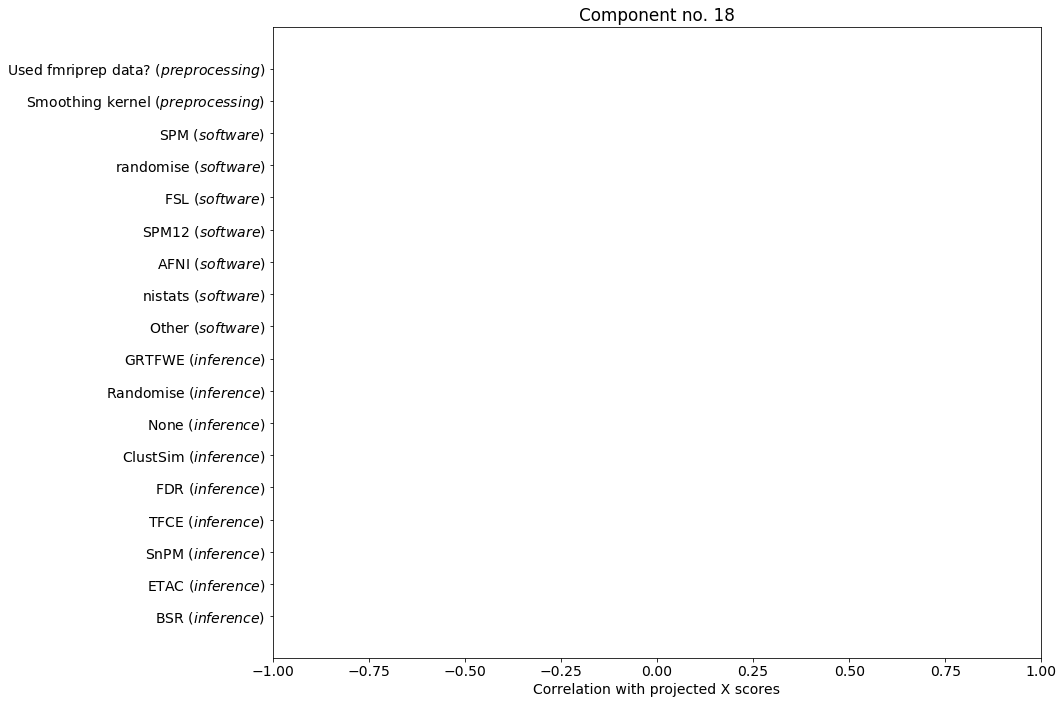

In [14]:
pipel_choices = list(pipel_num.columns)
labels = ['Used provided fmriprep data?',
          'Smoothing kernel',
          'T-stat software: SPM',
          'T-stat software: randomise',
          'T-stat software: FSL',
          'T-stat software: SPM12',
          'T-stat software: AFNI',
          'T-stat software: nistats',
          'T-stat software: Other',
          'Significance testing method: GRTFWE',
          'Significance testing method: Randomise',
          'Significance testing method: None',
          'Significance testing method: ClustSim',
          'Significance testing method: FDR',
          'Significance testing method: TFCE',
          'Significance testing method: SnPM',
          'Significance testing method: ETAC',
          'Significance testing method: BSR',
         ]
short_labels = [
          'Used fmriprep data? ($preprocessing$)',
          'Smoothing kernel ($preprocessing$)',
          'SPM ($software$)',
          'randomise ($software$)',
          'FSL ($software$)',
          'SPM12 ($software$)',
          'AFNI ($software$)',
          'nistats ($software$)',
          'Other ($software$)',
          'GRTFWE ($inference$)',
          'Randomise ($inference$)',
          'None ($inference$)',
          'ClustSim ($inference$)',
          'FDR ($inference$)',
          'TFCE ($inference$)',
          'SnPM ($inference$)',
          'ETAC ($inference$)',
          'BSR ($inference$)',
]
font = {'size'   : 14}
matplotlib.rc('font', **font)

y_corr = np.array(Y.T @ st.zscore(x_scores, ddof=1)) / (len(x_scores) - 1)

for ncomponent in np.arange(len(y_corr[0,:])):
#     for n, pipel_correlation in enumerate(y_corr[:, ncomponent]):
#         print('{:<39} r = {:>5.2f}'.format(labels[n] + ':',
#                                                           pipel_correlation))

    fig, ax = plt.subplots(figsize=(15,10))
    ax.barh(range(len(y_corr))[::-1], width=y_corr[:, ncomponent])
    ax.set(yticks=range(len(y_corr))[::-1], yticklabels=short_labels)
    ax.set(xlim=(-1, 1))
    ax.set(xlabel='Correlation with projected X scores')
    plt.title('Component no. %d' %int(ncomponent+1))
    fig.tight_layout()

This is great, but it would be nice to have some metrics to help determine
how many components we should be considering. Thankfully, we can do that in a
few different ways.

First, we can assess the effect size (or variance explained) explained by
each component. This is simply the squared singular value for each component
divided by the sum of all squared singular values. We'll plot this to get an
idea of how quickly it drops off.

We can use permutation sampling to perform null-hypothesis significance
testing in order to examine the extent to which the variance explained by
each component is greater than would be expected by chance.

Here, we'll permute one of our matrices (i.e., the ``Y`` matrix), re-generate
the cross-correlation matrix, and derive a new SVD space. To ensure the
dimensions we estimate are the "same" as the original SVD, we'll use an
orthogonal Procrustes rotation to align them, and then calculate the variance
explained by each of the "permuted" dimensions derived from the permuted
data. If we do this enough times we can generate a distribution of explained
variances for each component and use that to examine the relative likelihood
of our original components explaining as much variance as they do.

In [15]:
import pickle
datafile = '../data-narps/results1C_hypo%d.pickle' %hypothesis

if not run_long_analyses:
    with open(datafile, 'rb') as f:
        [bootstrap_ratios, y_corr, y_corr_ll, y_corr_ul, \
        x_error, x_scores, y_scores, \
        y_corr_distrib, U_sum, U_se, U_sum2, sval_perm, sprob,
        corr_real, corrs_perm] = \
        pickle.load(f)
        
varexp = sval ** 2 / sum(sval ** 2)

In [16]:
n_perm = 1000
if run_long_analyses:
    rs = np.random.RandomState(1234)  # Set a random seed for reproducibility
    varexp = sval ** 2 / sum(sval ** 2)
    sval_perm = np.zeros((len(varexp), n_perm))
    corrs_perm = []

    for n in range(n_perm):
        print(n/n_perm*100," percent complete         \r", end="")

        # Permute and z-score the Y matrix (leaving the X matrix intact)

        resamp = rs.permutation(len(Y))
        Yp = Y[resamp]#st.zscore(Y[resamp], ddof=1)

        # Regenerate the cross-correlation matrix and compute the decomposition
        cross_corr = (Yp.T @ Xz) / (len(Xz) - 1)
        U_new, sval_new, V_new = svd(cross_corr.T, full_matrices=False)
        V_new = V_new.T

        # Align the new singular vectors to the original using Procrustes. We can
        # do this with EITHER the left or right singular vectors; we'll use the
        # left vectors since they're much smaller in size so this is more
        # computationally efficient.
        N, _, P = svd(V.T @ V_new, full_matrices=False)
        aligned = V_new @ np.diag(sval_new) @ (P.T @ N.T)

        # Calculate the singular values for the rotated, permuted component space
        sval_perm[:, n] = np.sqrt(np.sum(aligned ** 2, axis=0))
        
        # calulate the correlation between the scores in the projected space, for the first component
        x_scores, y_scores = Xz @ U_new, Yp @ aligned
        n_comp = 1
        corr = st.spearmanr(x_scores[:, n_comp], y_scores[:, n_comp])
        corrs_perm.append(corr[0])

    # Calculate the number of permuted singular values larger than the original
    # and normalize by the number of permutations. We can treat this value as a
    # non-parametric p-value.
    sprob = (np.sum(sval_perm > sval[:, None], axis=1) + 1) / (n_perm + 1)
    for n, pval in enumerate(sprob):
        print('Component {}: non-parametric p = {:.3f}'.format(n, pval))


In [17]:
# for the significant component, calculate whether the correlation between 
# the two projected scores was significant
n_comp = 0
corr_real = st.spearmanr(x_scores[:, n_comp], y_scores[:, n_comp])[0]
r2_real = np.square(corr_real)
r2_perm = np.square(corrs_perm)
pval_corr_scores = (np.sum(r2_perm > r2_real) + 1) / (n_perm + 1)

print('Correlation between projected scores: R^2 = %.2f, non-parametric p = %.4f'\
          %(r2_real, pval_corr_scores))

Correlation between projected scores: R^2 = 0.00, non-parametric p = 0.9600


We can see that only the first component is "significant" with an alpha of
5% (i.e., _p_ < 0.05). This component also explained the majority of variance
in the data (>50%), so it seems like something we might want to investigate
more.

In order to begin to try and interpret the relationships between activation patterns and pipeline choices for that component it would be great to have an
estimate of the reliability of the component. This would give us an idea of
which voxels / pipeline choices are potentially "driving"
i.e., contributing the most to) the PLS component.

We can try and estimate this reliability using bootstrap resampling. Since
there are so many voxels (>16,000), we'll aim to generate a
"bootstrap ratio" for each voxel. This "bootstrap ratio" (or BSR) will
be calculate by dividing the original component weights in the left singular
vectors (the ``U`` matrix) with the standard error of the component weights
estimated by bootstrap resampling the original data. These BSRs can be used
as a sort of "z-score" proxy (assuming they're normally distributed), giving
us an idea of which voxels most strongly contribute to the
PLS dimensions estimated from our data.

On the other hand, since there are so few pipeline choices (only 18!), we can
use bootstrap resampling to generate actual confidence intervals (rather than
having to use bootstrap ratios as a proxy). These confidence intervals will
give us an idea of the pipeline choices most consistently related to the
activations in our ``X`` matrix.

Estimating these bootstrapped distributions is much more computationally
intensive than estimating permutations, so we're only going to do 50 (though
using a higher number would be better!).



In [18]:
if run_long_analyses:

    n_boot = 1000

    # It's too memory-intensive to hold all the bootstrapped functional connection
    # weights at once, especially if we're using a lot of bootstraps. Since we just
    # want to calculate the standard error of this distribution we can keep
    # estimates of the sum and the squared sum of the bootstrapped weights and
    # generate the standard error from those.
    U_sum = U @ np.diag(sval)
    U_square = (U @ np.diag(sval)) ** 2

    # We CAN store all the bootstrapped PANAS score correlations in memory, and
    # need to in order to correctly estimate the confidence intervals!
    y_corr_distrib = np.zeros((*V.shape, n_boot))

    for n in range(n_boot):
        print((n+1)/n_boot*100," percent complete         \r", end="")

        # Bootstrap resample and z-score BOTH X and Y matrices. Also convert NaN
        # values to 0 (in the event that resampling generates a column with
        # a standard deviation of 0).
        bootsamp = rs.choice(len(X), size=len(X), replace=True)
        Xb, Yb = X[bootsamp], Y[bootsamp]
        # Suppress invalid value in true_divide warnings (we're converting NaNs so
        # there's no point in getting annoying warnings about it).
        with np.errstate(invalid='ignore'):
            Xbz = np.nan_to_num(st.zscore(Xb, ddof=1))
            Ybz = np.nan_to_num(Yb)

        # Regenerate the cross-correlation matrix and compute the decomposition
        cross_corr = (Ybz.T @ Xbz) / (len(Xbz) - 1)
        U_new, sval_new, V_new = svd(cross_corr.T, full_matrices=False)

        # Align the left singular vectors to the original decomposition using
        # a Procrustes and store the sum / sum of squares for bootstrap ratio
        # calculation later
        N, _, P = svd(U.T @ U_new, full_matrices=False)
        aligned = U_new @ np.diag(sval_new) @ (P.T @ N.T)
        U_sum += aligned
        U_square += np.square(aligned)

        # Delete intermediate variables to reduce memory usage
        del cross_corr, U_new, sval_new, V_new, aligned

        # For the right singular vectors we actually want to calculate the
        # bootstrapped distribution of the CORRELATIONS between the original PANAS
        # scores and the projected X scores (like we estimated above!)
        #
        # We project the bootstrapped X matrix to the original component space and
        # then generate the cross-correlation matrix of the bootstrapped pipeline choice
        # with those projections
        Xbzs = st.zscore(Xb @ (U / np.linalg.norm(U, axis=0, keepdims=True)), ddof=1)
        y_corr_distrib[..., n] = (Ybz.T @ Xbzs) / (len(Xbzs) - 1)

        # Delete intermediate variables to reduce memory usage
        del Xbz, Ybz, Xbzs

    # Calculate the standard error of the bootstrapped functional connection
    # weights and generate bootstrap ratios from these values.
    U_sum2 = (U_sum ** 2) / (n_boot + 1)
    U_se = np.sqrt(np.abs(U_square - U_sum2) / (n_boot))
    bootstrap_ratios = (U @ np.diag(sval)) / U_se

    # Calculate the lower/upper confidence intervals of the bootrapped pipeline choice scores
    y_corr_ll, y_corr_ul = np.percentile(y_corr_distrib, [2.5, 97.5], axis=-1)

Now we can use these results to create figures

[Text(0.5, 1.0, 'ax4')]

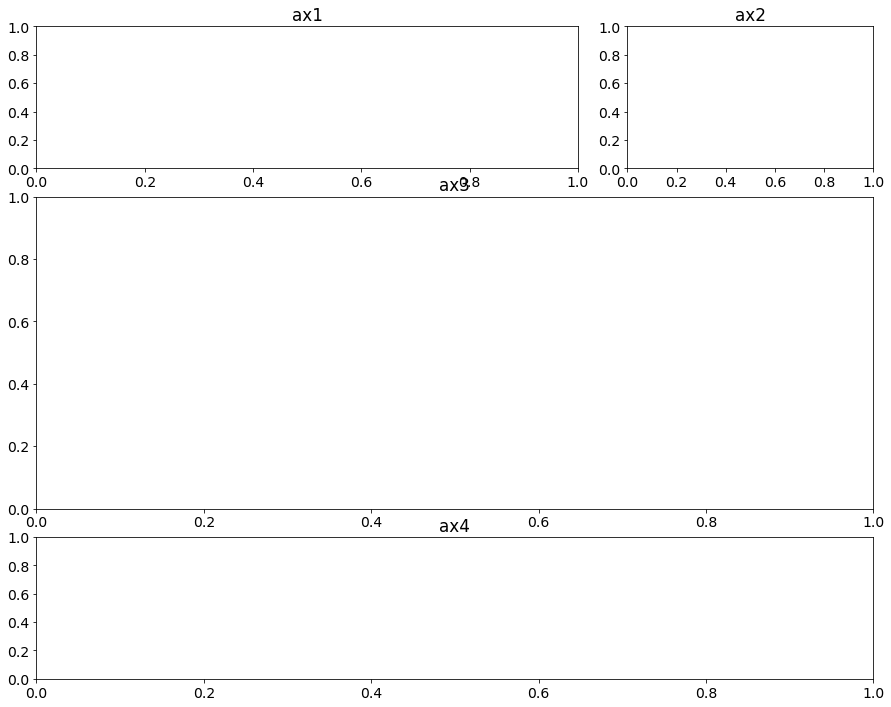

In [82]:
from matplotlib.gridspec import GridSpec

letter_font_size = 25
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(15,12))
gs = GridSpec(4,3, figure=fig)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[1:3, 0:3])
ax4 = plt.subplot(gs[3, :])

ax1.set(title='ax1')
ax2.set(title='ax2')
ax3.set(title='ax3')
ax4.set(title='ax4')


var explained  [9.65117694e-01 1.64473883e-02 6.07764293e-03 3.21331199e-03
 3.04348884e-03 1.89828059e-03 1.09827808e-03 7.86906479e-04
 5.83820479e-04 4.79576908e-04 4.11336165e-04 3.33071323e-04
 2.29786967e-04 1.41155032e-04 1.04589319e-04 3.36724515e-05
 1.12271830e-32 1.90844068e-34]
p-values  [0.00699301 0.1028971  0.38361638 0.64035964 0.76023976 0.85514486
 0.95004995 0.76823177 0.99000999 0.98801199 0.8961039  0.99400599
 0.99300699 1.         1.         1.         0.86513487 0.998002  ]
-0.03707518896498121 0.7901140993302715


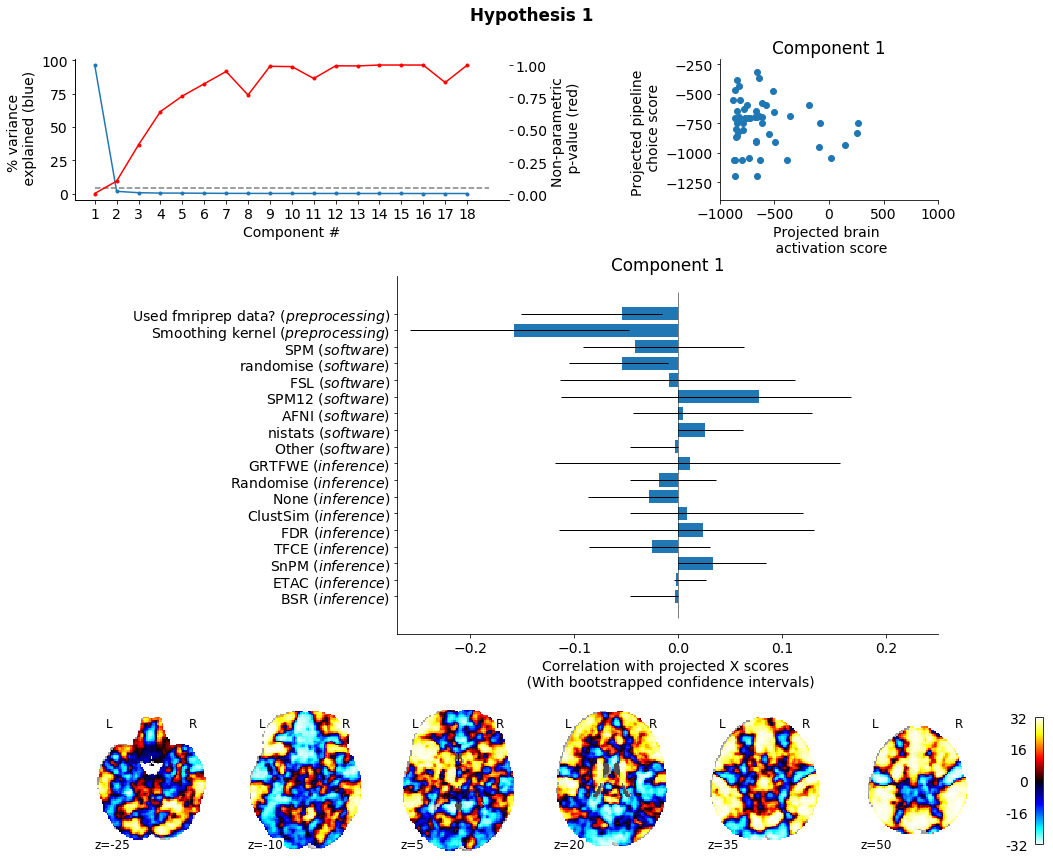

In [145]:
from matplotlib.gridspec import GridSpec

letter_font_size = 25
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(15,12))
gs = GridSpec(8,10, figure=fig)
ax1 = plt.subplot(gs[0:2, 0:5])
ax2 = plt.subplot(gs[0:2, 6:9])
ax3 = plt.subplot(gs[2:6, 3:9])
ax4 = plt.subplot(gs[6:, :])

n_components = len(y_corr[0,:])

ax1.plot(varexp * 100, '.-', label='variance')
print('var explained ', varexp)
ax1.set(xlabel='Component #', ylabel='% variance \n explained (blue)')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks(ticks=range(n_components))
ax1.set_xticklabels(labels=range(1, n_components+1))

ax1b = ax1.twinx()
ax1b.plot(sprob, '.-', color='red', label='$p$-values')
print('p-values ', sprob)
ax1b.set(xlabel='Component #', ylabel='Non-parametric \n p-value (red)')
ax1b.spines["top"].set_visible(False)
ax1b.spines["right"].set_visible(False)
ax1b.set_xticks(ticks=range(n_components))
ax1b.set_xticklabels(labels=range(1, n_components+1))
ax1b.hlines(y=.05, xmin=0, xmax=len(sprob), linestyles='dashed', color='grey',
            label='significance threshold (p<.05)')
fig.tight_layout()


n_comp = 0
x = np.squeeze(np.array(x_scores[:, n_comp].T))
y = np.squeeze(np.array(y_scores[:, n_comp].T))
r, p = st.spearmanr(x, y)
print(r, p)
ax2.scatter(x=x, y=y)
ax2.set(xlabel='Projected brain \n activation score', ylabel='Projected pipeline \n choice score',
       ylim=[-1400, -200], xlim=[-1000, 1000])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_title('Component %d' %int(n_comp + 1))
fig.tight_layout()

# Bars with CIs for the contribution of each analysis-choice variable to the significant component
ax3.barh(range(len(y_corr))[::-1], width=y_corr[:, n_comp],)
x_error = [y_corr_ll[:, 0] - y_corr[:, 0], y_corr_ul[:, 0] - y_corr[:, 0]]
ax3.errorbar(x=y_corr[:, 0], y=range(len(y_corr))[::-1],
         xerr=np.abs(x_error), fmt='none', ecolor='black', elinewidth=1)
ax3.vlines(0, *ax3.get_ylim(), linewidth=0.5)
ax3.set(yticks=range(len(y_corr))[::-1], yticklabels=short_labels)
ax3.set(xlabel='Correlation with projected X scores \n (With bootstrapped confidence intervals)',
        xlim=[-0.27, 0.25])
ax3.set_title('Component %d' %int(n_comp + 1))
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
fig.tight_layout()




arr = bootstrap_ratios[:,0]
nii = fun.flat_mat_to_nii(arr, ref_niimg=template, order=order)
plotting.plot_stat_map(nii, 
                           #title=name, 
                           display_mode='z',
                           cut_coords=z_cut_coords,
                           axes=ax4)
plt.suptitle('Hypothesis %d' %hypothesis, y=1.02, fontweight='bold')
fig.tight_layout()

if save_figs: plt.savefig('../figures/final_figures_paper/results1C_hypo%d_.png'\
                       %hypothesis, bbox_inches="tight")


In [96]:
p.frame_axes.figure.set_figure(ax4)

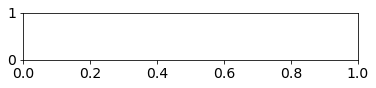

In [88]:
ax4 = plt.subplot(gs[3, :])
ax

In [78]:
ax4.set_figure(p)

RuntimeError: Can not put single artist in more than one figure

AttributeError: 'ZSlicer' object has no attribute 'set_figure'

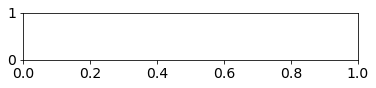

In [71]:
ax4 = plt.subplot(gs[3, :])
ax4.add_image(p)

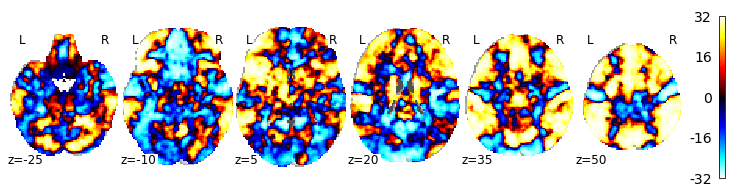

In [60]:
arr = bootstrap_ratios[:,0]
nii = fun.flat_mat_to_nii(arr, ref_niimg=template, order=order)
plotting.plot_stat_map(nii, 
                           #title=name, 
                           display_mode='z',
                           cut_coords=z_cut_coords,
                           figure=plt.figure(figsize=brain_fig_size))

if save_figs: plt.savefig('../figures/final_figures_paper/results1C_hypo%d_map_bootstrap_ratios.svg'
                         %hypothesis, bbox_inches="tight")

In [ ]:
if save_results: 
    with open(datafile, 'wb') as f:
        pickle.dump([bootstrap_ratios, y_corr, y_corr_ll, y_corr_ul, \
                    x_error, x_scores, y_scores, \
                    y_corr_distrib, U_sum, U_se, U_sum2, sval_perm, sprob,
                    corr_real, corrs_perm], f)

In [ ]:
from matplotlib.gridspec import GridSpec

letter_font_size = 25
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig, ax5 = plt.subplots(figsize=(10,12))

# reorder = np.array([8, 0, 1, 2, 3, 4, 5, 6, 7, 9, \
#                     10, 11, 12, 13, 14, 15, 16, 17]).astype(int)
# short_labels_r = np.squeeze(np.expand_dims(short_labels, axis=1)[reorder])
ax5.barh(range(len(y_corr))[::-1], width=y_corr[:, n_comp],)
x_error = [y_corr_ll[:, 0] - y_corr[:, 0], y_corr_ul[:, 0] - y_corr[:, 0]]
ax5.errorbar(x=y_corr[:, 0], y=range(len(y_corr))[::-1],
         xerr=np.abs(x_error), fmt='none', ecolor='black', elinewidth=1)
ax5.vlines(0, *ax5.get_ylim(), linewidth=0.5)
ax5.set(yticks=range(len(y_corr))[::-1], yticklabels=short_labels)
ax5.set(xlabel='Correlation with projected X scores \n (With bootstrapped confidence intervals)')
plt.title('Component %d' %int(n_comp+1))
fig.tight_layout()

#plt.title('$R^2_{spearman}$ = %.4f \n $p_{perm}$ = %.4f' \
#          %(r2_real, pval_corr_scores), loc='right', y=.8)


if save_figs: plt.savefig('../figures/final_figures_paper/results1C_hypo%d_just_bar.svg'\
                         %hypothesis, bbox_inches="tight")